# 🧞

In [47]:
import jax.numpy as jnp
import jax.scipy.stats as st
from jax import random, lax, vmap
import blackjax as bj
from blackjax import nuts, hmc, stan_warmup
import matplotlib.pyplot as plt
from datetime import datetime

Simple AR(1) model
$$ y_t = \mu + \rho y_{t-1} + \sigma \varepsilon_t, \qquad t=1,\dots,(N-1) $$
$$ y_0 = \frac{\mu}{1-\rho}+\varepsilon $$
$$ \varepsilon \sim \mathcal{N}\left( 0, 1\right) $$
We assume we also have priors
$$ \mu \sim N(0,1/10),
\qquad
\sigma \sim Gamma(2,2),
\qquad\mathrm{and}\qquad
\rho \sim Beta(2,2).
$$

In [2]:
# simulation parameters
N = 200
mu = 0.5
sigma = 2.0
rho = 0.9
seed = 42

In [3]:
key = random.PRNGKey(seed=seed)
key, subkey = random.split(key)
epsilon = random.normal(key, shape=(N,))
y = [mu*sigma/(1-rho) + epsilon[0]]
for t in range(1,N):
    y.append(mu + rho*y[t-1] + epsilon[t])
y = jnp.array(y)

In [4]:
def potential_fn(mu, sigma, rho):
    """Model potential, based on definition above."""
    log_prior = (
        st.norm.logpdf(mu,loc=0,scale=0.5)
        + st.gamma.logpdf(sigma,a=2,scale=1./2.)
        + st.beta.logpdf(rho,a=2,b=2)
    )
    log_lik = jnp.sum(st.norm.logpdf((y[1:] - mu - rho * y[:-1]), loc=0, scale=sigma))
    return -(log_prior + log_lik)


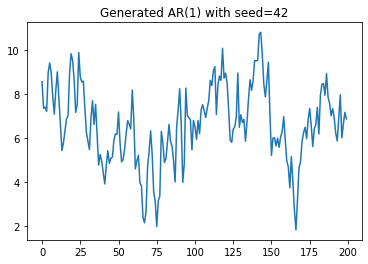

In [5]:
plt.plot(y)
plt.title(f'Generated AR(1) with seed={seed}');

In [6]:
# hmc_kernel = hmc.kernel(potential, step_size, inv_mass_matrix, num_integration_steps)
# hmc_kernel = jax.jit(hmc_kernel)

initial_position = {'mu': 0.0, 'sigma': 1.0, 'rho': 0.5}

In [67]:
def run_hmc(potential_fn, initial_position, draws=2000, warmup_steps=500, chains=40):
    """Run HMC after using Stan warmup with NUTS."""
    potential = lambda x: potential_fn(**x)
    assert jnp.isfinite(potential(initial_position))
    initial_state = nuts.new_state(initial_position, potential)

    # conduct Stan warmup
    kernel_factory = lambda step_size, mass_matrix: nuts.kernel(potential, step_size, mass_matrix)
    print(f'Step 1/3. Starting Stan warmup using NUTS...')
    start = datetime.now()
    state, (step_size, mass_matrix), adapt_chain = stan_warmup.run(
        key,
        kernel_factory,
        initial_state,
        num_steps=warmup_steps,
        is_mass_matrix_diagonal=True,
        initial_step_size=1e-3
    )
    elapsed = (datetime.now() - start).total_seconds()
    print(f'          {warmup_steps} warmup draws took {elapsed:.1f} sec ({warmup_steps/elapsed:.1f} iter/sec).')
    hmc_warmup_state, stan_warmup_state, nuts_info = adapt_chain
    assert jnp.isfinite(step_size), "Woops, step size is not finite."

    def inference_loop(rng_key, kernel, initial_state, num_samples, num_chains):
        def one_step(states, rng_key):
            keys = random.split(rng_key, num_chains)
            states, _ = vmap(kernel)(keys, states)
            return states, states
        keys = random.split(rng_key, num_samples)
        _, states = lax.scan(one_step, initial_state, keys)
        return states
    # FIXME: eventually we want median of NUTS draws from actual inference,
    #        because we're actually capturing different warmup stages
    int_steps = int(jnp.median(nuts_info.integration_steps[(warmup_steps//2):]))
    hmc_kernel = hmc.kernel(potential, step_size, mass_matrix, int_steps)
    
    # sample initial positions from second half of warmup
    start_idxs = random.choice(subkey, a=jnp.arange(warmup_steps//2, warmup_steps), shape=(chains,), replace=False)
    initial_positions = {k: hmc_state.position[k][start_idxs] for k in initial_position}
    initial_states = vmap(hmc.new_state, in_axes=(0, None))(initial_positions, potential)
    
    print(f'Step 2/3. Running main inference with {chains} chains...')
    start = datetime.now()
    states = inference_loop(key, hmc_kernel, initial_states, num_samples=draws, num_chains=chains)
    elapsed = (datetime.now() - start).total_seconds()
    print(f'          {chains*draws} HMC draws took {elapsed:.1f} sec ({chains*draws/elapsed:.1f} iter/sec).')

    print(f'Step 3/3. Running LOO-CV with {chains} chains...')
    start = datetime.now()
    states = inference_loop(key, hmc_kernel, initial_states, num_samples=draws, num_chains=chains)
    elapsed = (datetime.now() - start).total_seconds()
    print(f'          {chains*draws} HMC draws took {elapsed:.1f} sec ({chains*draws/elapsed:.1f} iter/sec).')

    return states

In [68]:
states = run_hmc(potential_fn, initial_position, draws=2_000, warmup_steps=500, chains=10_000)

Step 1/3. Starting Stan warmup using NUTS...
          500 warmup draws took 10.4 sec (47.9 iter/sec).
Step 2/3. Running main inference with 40 chains...
          80000 HMC draws took 3.8 sec (21316.2 iter/sec).
Step 3/3. Running LOO-CV with 40 chains...
          80000 HMC draws took 3.8 sec (20781.0 iter/sec).


In [79]:
states.position["mu"].block_until_ready();

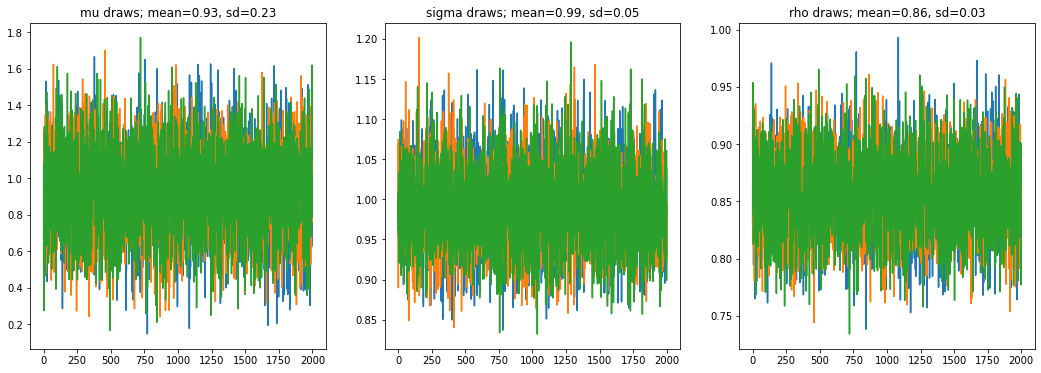

In [80]:
fig, axes = plt.subplots(ncols=3, figsize=(18,6))
param_names = list(initial_position.keys())
for ax, name in zip(axes, param_names):
    draws = states.position[name]
    for chain in range(3):
        ax.plot(draws[:,chain])
    mean, sd = jnp.mean(draws), jnp.std(draws)
    ax.set_title(f'{name} draws; mean={mean:.2f}, sd={sd:.2f}')

In [81]:
import arviz as az

/home/acooper/src/ploo/venv/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (2000) than draws (40). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


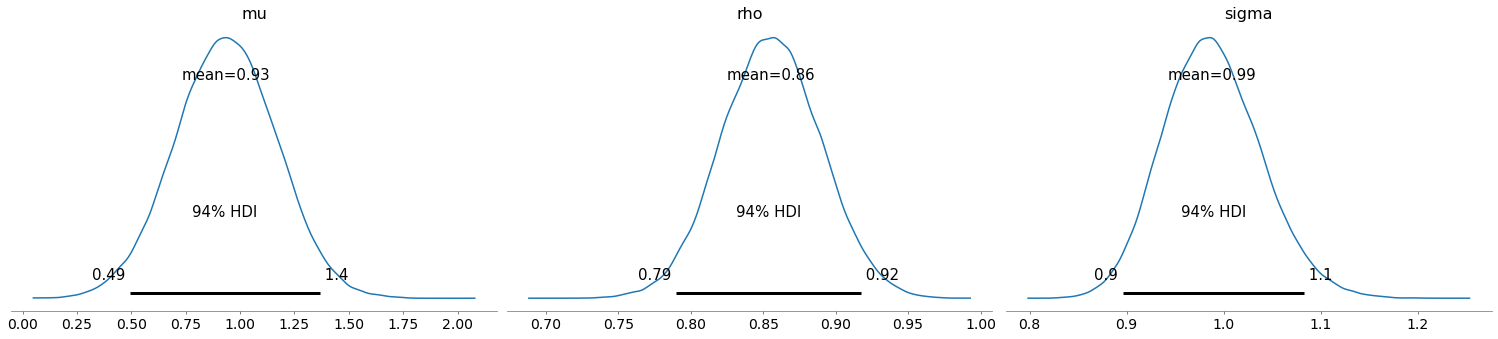

In [82]:
az.plot_posterior(states.position);

/home/acooper/src/ploo/venv/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (2000) than draws (40). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


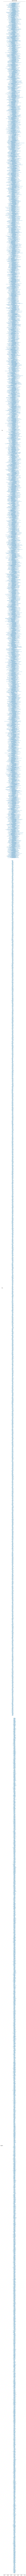

In [83]:
az.plot_forest(states.position);

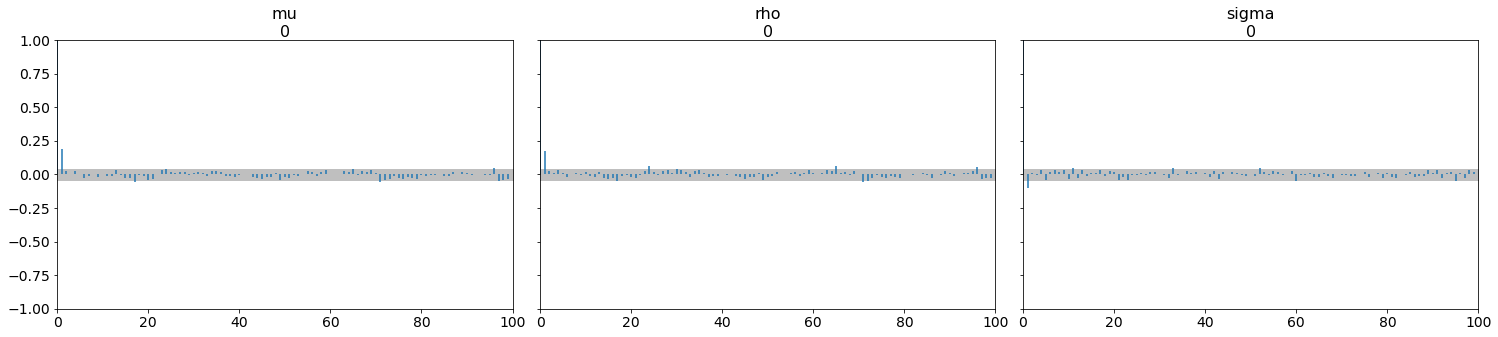

In [14]:
az.plot_autocorr(states.position);